# 1D function models

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from tqdm.notebook import tqdm
import pandas as pd

from physics_mi.utils import set_all_seeds

In [3]:
seed = np.random.randint(1, 2**32 - 1)
# seed = 3243091524  # this one is very interesting
# pleasingly_symmetric_seed = 95433229
set_all_seeds(seed)
print(seed)

1028516357


In [148]:
class config:
    # 1D function model(s)
    N_FUNCS = 10
    TRAIN_SIZE = 8000
    VALID_SIZE = 2000
    MODELS_PER_FUNC = 50
    MODEL_HIDDEN_DIM = 64

    # Embedder model
    N_SAMPLES = 32
    EPOCHS = 200

## Train source models

Not sure what to call these - so many models to refer to. These are the ones I'm going to classify.

In [149]:
from physics_mi.eval import *


def generate_polynomial(n=20):
    coeffs = np.random.rand(n) * 2 - 1
    return np.polynomial.Polynomial(coeffs)


def generate_waveform(n=10, frequency_scale=0.7):
    """
    Generates a funky curve using a Fourier series with n terms, in a vectorized manner.

    Parameters:
    - n: Number of terms in the Fourier series.
    - frequency_scale: Scales the frequencies of the sine and cosine terms.

    Returns:
    A function that takes an array of x values and returns the corresponding y values, calculated in a vectorized way.
    """
    # Random coefficients for sine and cosine terms
    a_coeffs = np.random.rand(n) * 2 - 1  # Coefficients for cosine terms
    b_coeffs = np.random.rand(n) * 2 - 1  # Coefficients for sine terms
    frequencies = np.arange(1, n + 1) * frequency_scale  # Frequency scaling

    def fourier_series(x):
        # Creating a 2D grid where each row corresponds to x and each column to a term in the series
        x_grid = np.outer(x, frequencies)

        # Calculating the sum of all sine and cosine terms at once
        y = np.dot(np.cos(np.pi * x_grid), a_coeffs) + np.dot(np.sin(np.pi * x_grid), b_coeffs)
        return y

    return fourier_series


def plot_funcs(funcs):
    _, axes = plt.subplots(2, 5, figsize=(15, 6))

    x = np.linspace(-1, 1, 100)
    for i, (ax, func) in enumerate(zip(axes.flatten(), funcs)):
        ax.plot(x, func(x))
        ax.set_title(f"Function {i}")


def generate_X(size):
    return np.random.rand(size) * 2 - 1


class FuncData:
    def __init__(self, func, size: int) -> None:
        self.func = func
        self.size = size
        self.X = generate_X(size)
        self.Y = self.func(self.X)
        self.torchify_data()

    def torchify_data(self):
        self.X = torch.as_tensor(self.X).float()[:, None]
        self.Y = torch.as_tensor(self.Y).float()[:, None]


def generate_func_data(funcs, train_size, valid_size):
    return [
        {
            "train": FuncData(func, train_size),
            "valid": FuncData(func, valid_size),
        }
        for func in funcs
    ]


class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=16, output_dim=2, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(input_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, output_dim, use_act=False),
        )

    def forward(self, x):
        return self.layers(x)


def get_model():
    return Net(input_dim=1, hidden_dim=config.MODEL_HIDDEN_DIM, output_dim=1)


def train_model(train_data, valid_data):
    N = 100  # number of epochs

    model = Net(input_dim=1, hidden_dim=config.MODEL_HIDDEN_DIM, output_dim=1)
    loss_func = nn.MSELoss()
    optimiser = Adam(model.parameters(), lr=1e-1)
    log = []

    for i in range(N):
        log_sample = {}

        # Training update
        model.train()
        model.zero_grad()
        Y_hat = model(train_data.X)
        loss = loss_func(Y_hat, train_data.Y)
        log_sample["train_loss"] = float(loss.detach())
        loss.backward()
        optimiser.step()

        # Validation set
        model.eval()
        Y_hat = model(valid_data.X)
        loss = loss_func(Y_hat, valid_data.Y)
        log_sample["valid_loss"] = float(loss.detach())

        log.append(log_sample)

    log = pd.DataFrame(log)

    return model, log


def get_preds(model, valid_data):
    model.eval()

    with torch.inference_mode():
        out = model(valid_data.X)

    y_preds = out.numpy()[:, 0]
    y_targs = valid_data.Y.numpy()[:, 0]

    return y_preds, y_targs


def plot_models(df, data, title=None):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    pdf = df.reset_index(drop=True)

    for ax, (i, row) in zip(axes.flatten(), pdf.iterrows()):
        model = get_model()
        model.load_state_dict(row["model"])
        valid_data = data[row["func"]]["valid"]

        y_preds, _ = get_preds(model, valid_data)

        sort_idxs = torch.argsort(valid_data.X[:, 0]).numpy()
        x = valid_data.X.numpy()[sort_idxs]
        y = valid_data.Y.numpy()[sort_idxs]
        y_preds_plot = y_preds[sort_idxs]

        ax.scatter(x, y_preds_plot, s=5, label="Predicted", alpha=0.5, color="grey")
        ax.plot(x, y, label="True", color="salmon")

        _ = ax.set_title(f"Function {i}")

    if title is not None:
        fig.suptitle(title)

In [150]:
funcs = [generate_waveform() for _ in range(config.N_FUNCS)]
data = generate_func_data(funcs, train_size=config.TRAIN_SIZE, valid_size=config.VALID_SIZE)

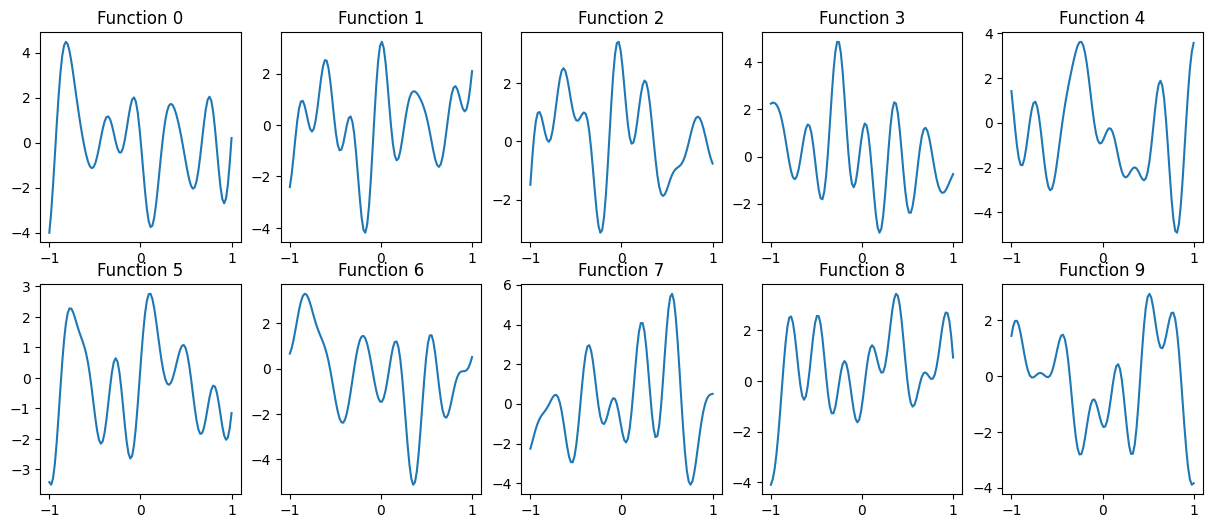

In [151]:
plot_funcs(funcs)

In [ ]:
models = []
for i, (func, func_data) in tqdm(enumerate(zip(funcs, data)), total=len(data)):
    for j in tqdm(range(config.MODELS_PER_FUNC), leave=False):
        model, log = train_model(func_data["train"], func_data["valid"])
        row = {}
        row["func"] = i
        row["repeat"] = j
        row["model"] = model.state_dict()
        row["valid_loss"] = log["valid_loss"].iloc[-1]
        models.append(row)
    print("\n")

mdf = pd.DataFrame(models)

In [153]:
mdf.loc[mdf["repeat"] == 0]

,func,repeat,model,valid_loss
0,0,0,"{'layers.0.linear.weight': [[tensor(-0.5741)],...",1.154331
50,1,0,"{'layers.0.linear.weight': [[tensor(-0.1895)],...",2.038372
100,2,0,"{'layers.0.linear.weight': [[tensor(0.8275)], ...",1.105606
150,3,0,"{'layers.0.linear.weight': [[tensor(-0.2048)],...",1.697625
200,4,0,"{'layers.0.linear.weight': [[tensor(-0.8282)],...",2.916994
250,5,0,"{'layers.0.linear.weight': [[tensor(-0.1469)],...",2.338434
300,6,0,"{'layers.0.linear.weight': [[tensor(-0.1251)],...",2.022895
350,7,0,"{'layers.0.linear.weight': [[tensor(0.0652)], ...",1.435616
400,8,0,"{'layers.0.linear.weight': [[tensor(-0.8408)],...",0.616981
450,9,0,"{'layers.0.linear.weight': [[tensor(0.9809)], ...",0.787136


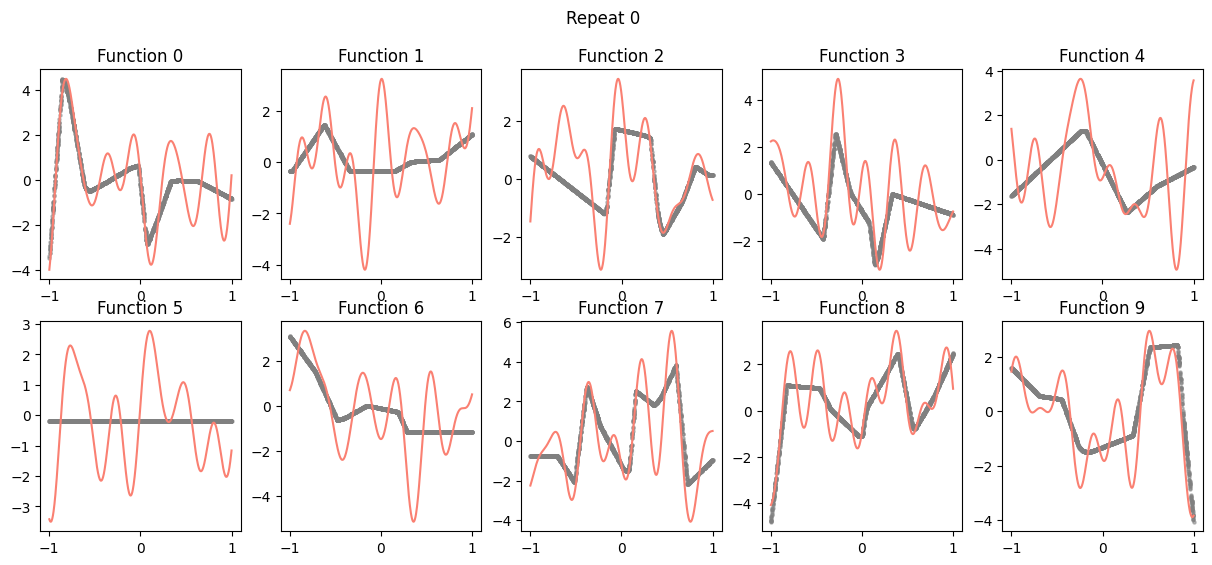

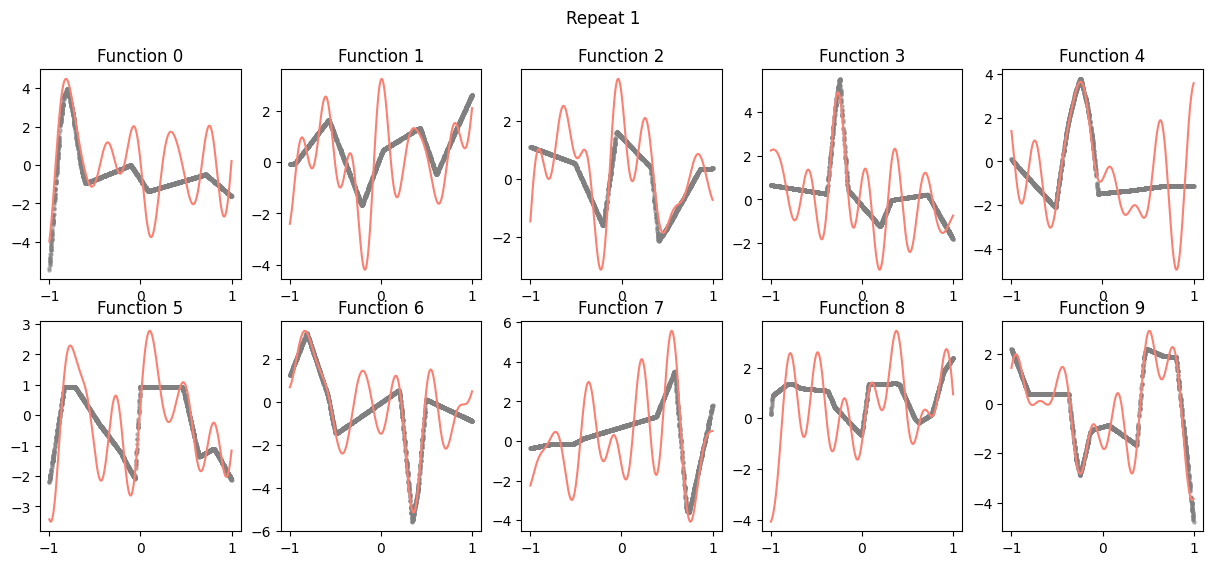

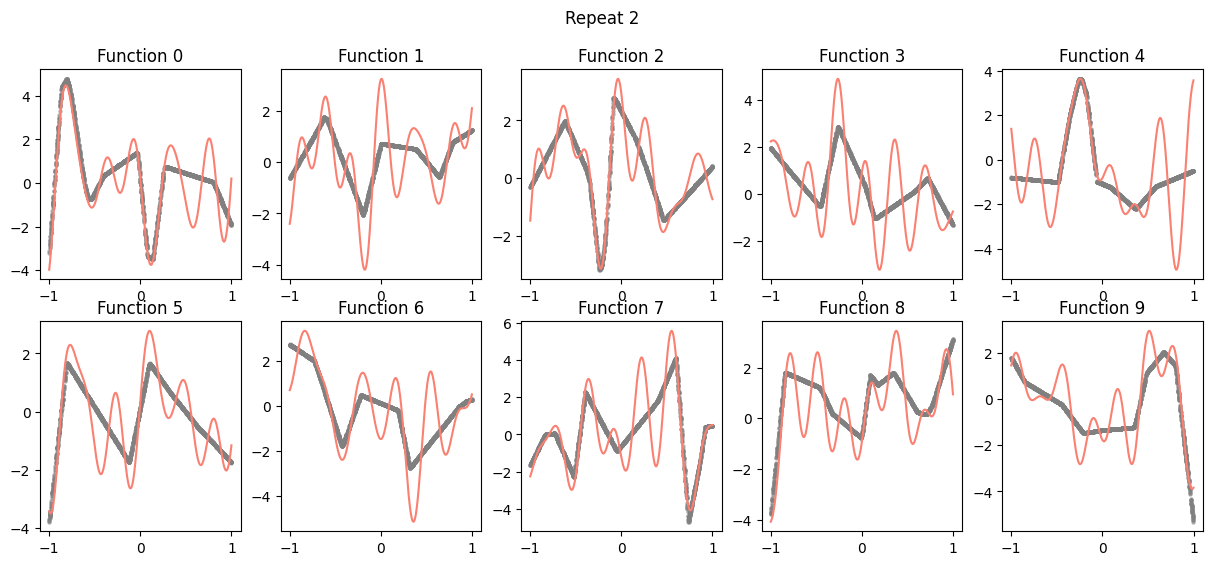

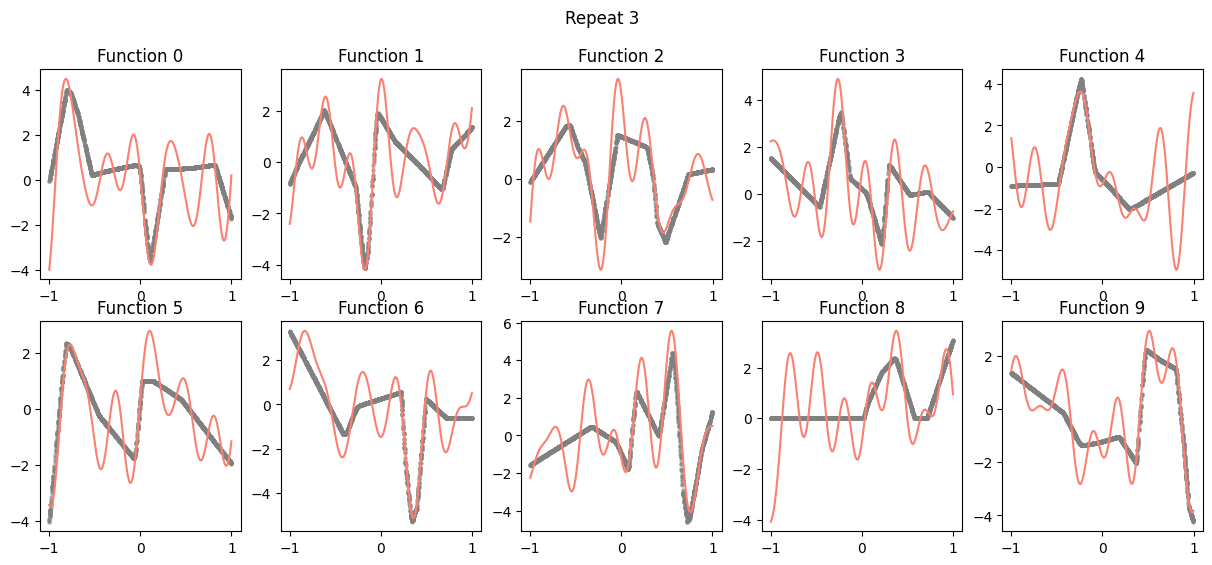

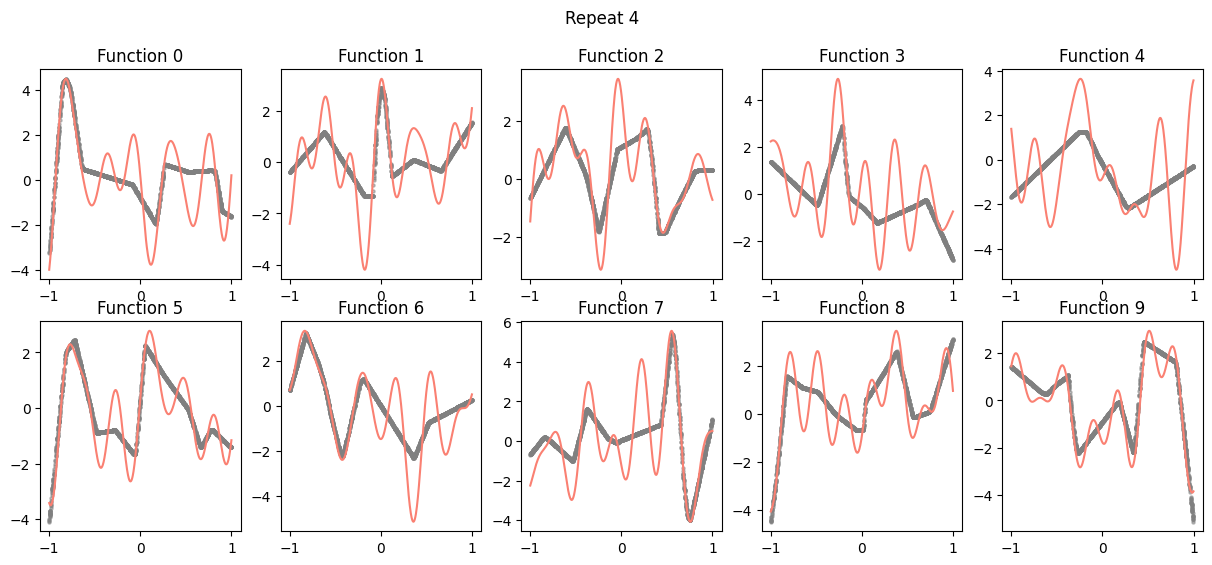

In [154]:
for i in range(5):
    plot_models(mdf.loc[mdf["repeat"] == i], data, title=f"Repeat {i}")

Now plotting all the repeats for each function to see if they're distinguishable:

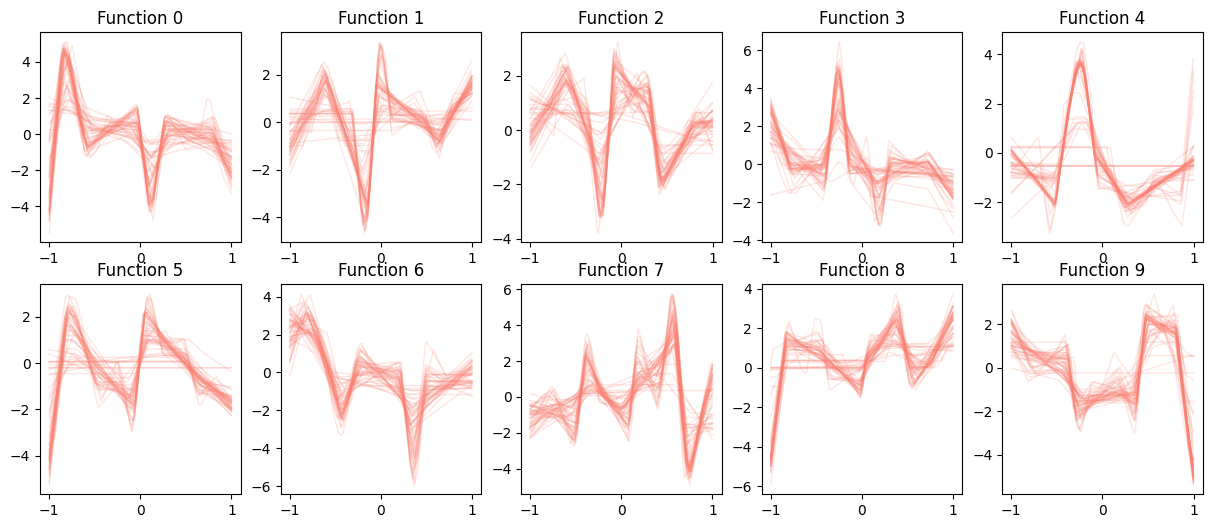

In [174]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for f, ax in enumerate(axes.flatten()):
    valid_data = data[f]["valid"]
    sort_idxs = torch.argsort(valid_data.X[:, 0]).numpy()
    x = valid_data.X.numpy()[sort_idxs]
    for r in range(config.MODELS_PER_FUNC):
        row = mdf.loc[(mdf["func"] == f) & (mdf["repeat"] == r)].iloc[0]
        model = get_model()
        model.load_state_dict(row["model"])

        y_preds, _ = get_preds(model, valid_data)
        y_preds_plot = y_preds[sort_idxs]

        ax.plot(x, y_preds_plot, lw=1, label="Predicted", alpha=0.2, color="salmon")
    ax.set_title(f"Function {f}")

Ok so we can see that there is some underfitting (could probably have increased model capacity/decreased number of fourier components) but importantly, the shape between repeats seems to be fairly consistent (and distinct) 👍 which is what we need for the next model to learn distinguishing features.

In [170]:
# mdf.to_pickle("models/fourier_models.pkl")

## Train model embedder

Here's where it gets interesting.

So far we've trained 50 different networks to model each of our 10 1D polynomials. The plan now is to use these as training data for our auxiliary model i.e. the one that's going to be generating embeddings. 

### Data

In [420]:
mdf = pd.read_pickle("models/fourier_models.pkl")

<Axes: >

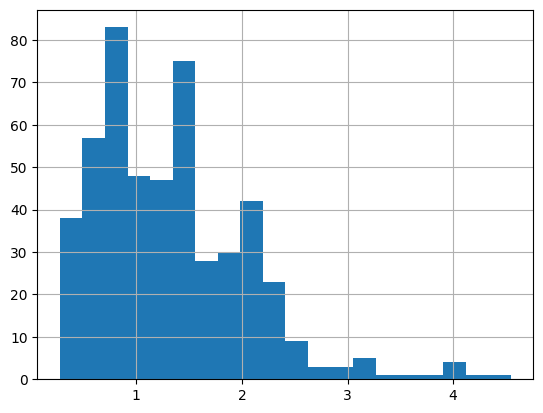

In [421]:
mdf.valid_loss.hist(bins=20)

Let's remove some of those high-loss models that probably aren't going to provide us with enough line sections to learn anything meaningful.

In [422]:
(mdf.valid_loss < 2).mean()

0.814

In [423]:
mdf = mdf.loc[mdf.valid_loss < 2.5].reset_index(drop=True)
mdf.groupby("func")["func"].count()

func
0    47
1    50
2    50
3    46
4    38
5    50
6    50
7    45
8    50
9    49
Name: func, dtype: int64

Some functions were obviously harder to model than others.

In [424]:
from physics_mi.utils import unique


class GradientDataset(Dataset):
    def __init__(self, df: pd.DataFrame, n_samples: int = 10):
        self.df = df.reset_index(drop=True)
        self.n_samples = n_samples

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        model = get_model()
        model.load_state_dict(row["model"])
        for param in model.parameters():
            param.requires_grad = False
        X = torch.as_tensor(generate_X(self.n_samples)).float()
        X = torch.sort(X)[0][:, None]
        X.requires_grad_(True)
        out = model(X)
        loss = out.mean()
        loss.backward()
        input_grads = X.grad.clone().detach()
        stack = torch.cat([X, input_grads], dim=1)
        uq_grads, _, _, index = unique(input_grads)
        uq_grads = uq_grads[torch.argsort(index)]
        n_grads = len(uq_grads)
        window_size = int(n_grads // 3)
        window_start = np.random.randint(0, n_grads - window_size)
        mask_grads = uq_grads[window_start : window_start + window_size]
        mask = torch.isin(stack[:, 1], mask_grads)
        masked = stack.clone()
        masked[mask, 1] = -1
        x = masked.view(-1)
        y = stack[:, 1]  # TODO potentially mask out the y values too in order to focus the loss
        x = x.detach()
        y = y.detach()
        return x, y

In [425]:
from sklearn.model_selection import train_test_split

train_idxs, valid_idxs = train_test_split(mdf.index, test_size=0.2, stratify=mdf["func"])
mdf["valid"] = False
mdf.loc[valid_idxs, "valid"] = True

mdf.groupby("func")["valid"].value_counts()

func  valid
0     False    38
      True      9
1     False    40
      True     10
2     False    40
      True     10
3     False    37
      True      9
4     False    30
      True      8
5     False    40
      True     10
6     False    40
      True     10
7     False    36
      True      9
8     False    40
      True     10
9     False    39
      True     10
Name: count, dtype: int64

In [426]:
train_ds = GradientDataset(mdf.loc[~mdf["valid"]], n_samples=config.N_SAMPLES)
valid_ds = GradientDataset(mdf.loc[mdf["valid"]], n_samples=config.N_SAMPLES)

len(train_ds), len(valid_ds)

(380, 95)

In [427]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=False)

xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([64, 64]), torch.Size([64, 32]))

### Model

Going to add in a residual connection so that it can copy the unchanged grad inputs if it would like:

In [457]:
class GradNet(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=16, output_dim=2, embedding_mode=False, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(input_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, output_dim, use_act=False),
        )
        self.output_layer = LinearLayer(output_dim, output_dim, use_act=False)
        self.embedding_mode = embedding_mode

    def forward(self, x):
        out = self.layers(x)
        out = out + x.view(x.shape[0], -1, 2)[:, :, 1]  # residual connection
        if self.embedding_mode:
            return out
        return self.output_layer(out)

### Train

In [458]:
from torch.optim.lr_scheduler import OneCycleLR

model = GradNet(input_dim=64, hidden_dim=128, output_dim=32)
optimiser = Adam(model.parameters(), lr=1e-3)
loss_func = nn.MSELoss()
total_steps = len(train_dl) * config.EPOCHS
scheduler = OneCycleLR(optimiser, max_lr=1e-2, total_steps=total_steps)

log = []

for epoch in tqdm(range(config.EPOCHS)):
    log_sample = {}

    model.train()
    for xb, yb in train_dl:
        y_hat = model(xb)
        # mask = xb.view(len(xb), -1, 2)[:, :, 1] == -1
        # loss = loss_func(y_hat[mask], yb[mask])
        loss = loss_func(y_hat, yb)
        loss.backward()
        optimiser.step()
        optimiser.zero_grad()
        scheduler.step()

    model.eval()
    valid_loss = 0
    for xb, yb in valid_dl:
        with torch.no_grad():
            y_hat = model(xb)
            # mask = xb.view(len(xb), -1, 2)[:, :, 1] == -1
            # valid_loss += nn.MSELoss()(y_hat[mask], yb[mask])
            valid_loss += nn.MSELoss()(y_hat, yb)

    log_sample["valid_loss"] = float(valid_loss / len(valid_dl))
    log_sample["train_loss"] = float(loss)
    log.append(log_sample)

log = pd.DataFrame(log)

  0%|          | 0/200 [00:00<?, ?it/s]

In [459]:
# torch.save(model.state_dict(), "models/gradnet_fourier.pth")

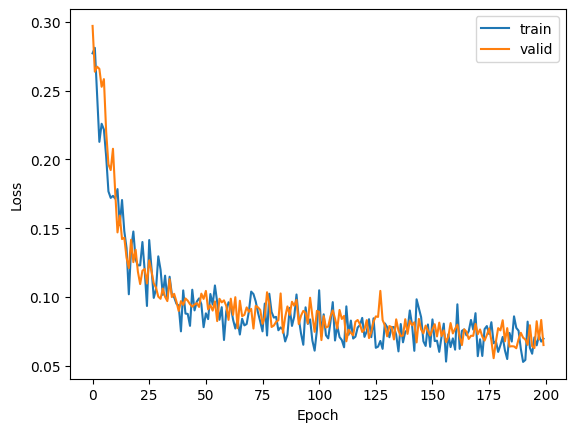

In [460]:
plot_loss(log["train_loss"], log["valid_loss"])

In [461]:
def get_preds(model, valid_dl):
    model.eval()

    X = []
    y_preds = []
    y_targs = []

    for xb, yb in valid_dl:
        with torch.inference_mode():
            out = model(xb)
        X.append(xb)
        y_preds.append(out)
        y_targs.append(yb)

    X = torch.cat(X).numpy()
    y_preds = torch.cat(y_preds).numpy()
    y_targs = torch.cat(y_targs).numpy()

    return y_preds, y_targs, X

In [462]:
y_preds, y_targs, X = get_preds(model, valid_dl)

X_x = X.reshape(len(X), -1, 2)[:, :, 0]
cloze_mask = X.reshape(len(X), -1, 2)[:, :, 1] == -1
y_preds.shape, y_targs.shape, cloze_mask.shape, X_x.shape

((95, 32), (95, 32), (95, 32), (95, 32))

In [463]:
i = 0

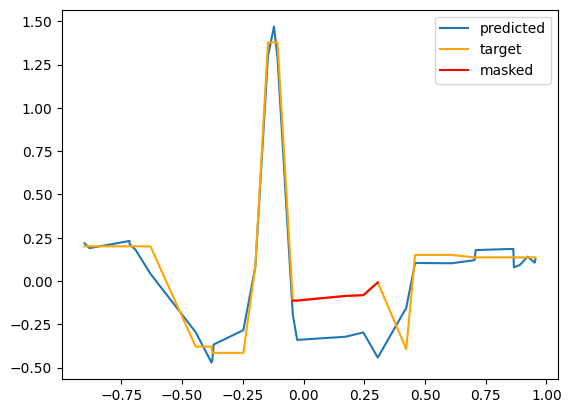

In [489]:
fig, ax = plt.subplots()

func = funcs[valid_ds.df.loc[i, "func"]]

ax.plot(X_x[i], y_preds[i], label="predicted")
ax.plot(X_x[i], y_targs[i], label="target", color="orange")
ax.plot(X_x[i, cloze_mask[i]], y_targs[i, cloze_mask[i]], color="red", label="masked")
_ = ax.legend()
i += 1

Ok, it's by no means perfect, but it's doing ok enough I think to move to the next stage: visualising the embeddings.

### Embedding visualisation

In [490]:
embedder = GradNet(input_dim=64, hidden_dim=128, output_dim=32, embedding_mode=True)
embedder.load_state_dict(model.state_dict())

<All keys matched successfully>

In [491]:
y_preds, y_targs, X = get_preds(embedder, valid_dl)

In [492]:
func_labels = valid_ds.df["func"].values
y_preds.shape, func_labels.shape

((95, 32), (95,))

In [493]:
from pacmap import PaCMAP

model = PaCMAP()

y_preds_2d = model.fit_transform(y_preds)

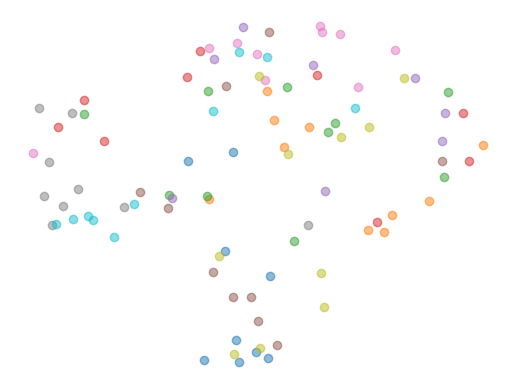

In [494]:
fig, ax = plt.subplots()

for lbl in np.unique(func_labels):
    mask = func_labels == lbl
    ax.scatter(y_preds_2d[mask, 0], y_preds_2d[mask, 1], label=f"Function {lbl}", alpha=0.5)

_ = ax.axis("off")

Maybe there's _some_ structure in this space? I'm not sure if that's trivially true though anyway because each function has a different shape and we're outputting the shape 🤷 I'm also aware that my model has overfit and generally isn't performing so well. I think for these we need to train a nice well-performing model before we see any clean results.

I'm going to roll back a bit in the next notebook and try and simpler straight up classification of the functions from their gradients. This should be easier and hopefully at least tell me that enough information is there. Then the task goes back to whether we can come up with an unsupervised method for extracting embeddings (because in real-world applications we cannot train in a supervised way). 